In [ ]:
# default_exp core

# hmc

> API details.


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np

import dipy.align as dpa
from dipy.io.utils import read_img_arr_or_path
from dipy.reconst.sfm import (SparseFascicleModel, SparseFascicleFit,
                              IsotropicFit, IsotropicModel,
                              _to_fit_iso, nanmean)
import dipy.core.gradients as dpg
import collections
import nibabel as nib
from sklearn.base import RegressorMixin
from dipy.segment.mask import median_otsu
import warnings


In [ ]:
#export
from functools import partial
from scipy.linalg import svd 
svd = partial(svd, full_matrices=False)

def _do_svd(X, y, jit=True):
    """
    Helper function to produce SVD outputs
    """
    if len(y.shape) == 1:
        y = y[:, np.newaxis]

    if X.shape[0] > X.shape[1]:
        uu, ss, v_t = svd(X.T @ X)
        selt = np.sqrt(ss)
        if y.shape[-1] >= X.shape[0]:
            ynew = (1/selt) @ v_t @ X.T @ y
        else:
            ynew = np.diag(1./selt) @ v_t @ (X.T @ y)

    else:
        uu, selt, v_t = svd(X)
        # This rotates the targets by the unitary matrix uu.T:
        ynew = uu.T @ y

    ols_coef = (ynew.T / selt).T

    return uu, selt, v_t, ols_coef


In [ ]:
#export
class ExponentialIsotropicModel(IsotropicModel):
    """
    Representing the isotropic signal as a fit to an exponential decay function
    with b-values
    """
    def fit(self, data, mask=None):
        """

        Parameters
        ----------
        data : ndarray

        Returns
        -------
        ExponentialIsotropicFit class instance.
        """
        to_fit = _to_fit_iso(data, self.gtab, mask=mask)
        # Fitting to the log-transformed relative data is much faster:
        nz_idx = to_fit > 0
        to_fit[nz_idx] = np.log(to_fit[nz_idx])
        to_fit[~nz_idx] = -np.inf
        p = nanmean(to_fit / self.gtab.bvals[~self.gtab.b0s_mask], -1)
        params = -p
        if mask is None:
            params = np.reshape(params, data.shape[:-1])
        else:
            out_params = np.zeros(data.shape[:-1])
            out_params[mask] = params
            params = out_params
        return ExponentialIsotropicFit(self, params)

In [ ]:
#export
class ExponentialIsotropicFit(IsotropicFit):
    """
    A fit to the ExponentialIsotropicModel object, based on data.
    """
    def predict(self, gtab=None):
        """
        Predict the isotropic signal, based on a gradient table. In this case,
        the prediction will be for an exponential decay with the mean
        diffusivity derived from the data that was fit.

        Parameters
        ----------
        gtab : a GradientTable class instance (optional)
            Defaults to use the gtab from the IsotropicModel from which this
            fit was derived.
        """
        if gtab is None:
            gtab = self.model.gtab
        if len(self.params.shape) == 0:
            pred = np.exp(-gtab.bvals[~gtab.b0s_mask] *
                          (np.zeros(np.sum(~gtab.b0s_mask)) +
                          self.params[..., np.newaxis]))
        else:
            pred = np.exp(-gtab.bvals[~gtab.b0s_mask] *
                          (np.zeros((self.params.shape +
                                     (int(np.sum(~gtab.b0s_mask)), ))) +
                          self.params[..., np.newaxis]))
        return pred

In [ ]:
#export
BIG_BIAS = 10e3
SMALL_BIAS = 10e-3
BIAS_STEP = 0.2


class SFM4HMC(SparseFascicleModel):
    """
    We need to reimplement the fit, so that we can use the FRR cleverness
    under the hood
    """
    def fit(self, data, alpha=0.1, mask=None, tol=10e-10, iso_params=None):
        """
        Fit the SparseFascicleModel object to data.

        Parameters
        ----------
        data : array
            The measured signal.

        mask : array, optional
            A boolean array used to mark the coordinates in the data that
            should be analyzed. Has the shape `data.shape[:-1]`. Default: None,
            which implies that all points should be analyzed.

        Returns
        -------
        SparseFascicleFit object
        """
        # if mask is None:
        #     # Flatten it to 2D either way:
        #     data_in_mask = np.reshape(data, (-1, data.shape[-1]))
        # else:
        #     # Check for valid shape of the mask
        #     if mask.shape != data.shape[:-1]:
        #         raise ValueError("Mask is not the same shape as data.")
        #     mask = np.array(mask, dtype=bool, copy=False)
        #     data_in_mask = np.reshape(data[mask], (-1, data.shape[-1]))

        data_in_mask = data[mask]
        # Fitting is done on the relative signal (S/S0):
        flat_S0 = np.mean(data_in_mask[..., self.gtab.b0s_mask], -1)
        if not flat_S0.size or not flat_S0.max():
            flat_S = np.zeros(data_in_mask[..., ~self.gtab.b0s_mask].shape)
        else:
            flat_S = (data_in_mask[..., ~self.gtab.b0s_mask] /
                      flat_S0[..., None])

        if iso_params is None:
            isotropic = self.isotropic(self.gtab).fit(data, mask)            
        else:
            isotropic = ExponentialIsotropicFit(self.isotropic(self.gtab), iso_params)

        isopredict = isotropic.predict()

        if mask is None:
            isopredict = np.reshape(isopredict, (-1, isopredict.shape[-1]))
        else:
            isopredict = isopredict[mask]

        # Here's where things get different: ##
        y = (flat_S - isopredict).T
        # Making sure nan voxels get 0 params:
        nan_targets = np.unique(np.where(~np.isfinite(y))[1])
        y[:, nan_targets] = 0

        ### FIT FRACRIDGE
        uu, selt, v_t, ols_coef = _do_svd(self.design_matrix, y)
        # Set solutions for small eigenvalues to 0 for all targets:
        isbad = selt < tol
        if np.any(isbad):
            warnings.warn("Some eigenvalues are being treated as 0")

        ols_coef[isbad, ...] = 0
        seltsq = selt**2
        sclg = seltsq / (seltsq + alpha)
        coef = sclg[:, np.newaxis] * ols_coef
        coef = v_t.T @ coef
        # # Limits on the grid of candidate alphas used for interpolation:
        # val1 = BIG_BIAS * selt[0] ** 2
        # val2 = SMALL_BIAS * selt[-1] ** 2

        # # Generates the grid of candidate alphas used in interpolation:
        # alphagrid = np.concatenate(
        #     [np.array([0]),
        #     10 ** np.arange(np.floor(np.log10(val2)),
        #                     np.ceil(np.log10(val1)), BIAS_STEP)])

        # # The scaling factor applied to coefficients in the rotated space is
        # # lambda**2 / (lambda**2 + alpha), where lambda are the singular values
        # seltsq = selt**2
        # sclg = seltsq / (seltsq + alphagrid[:, None])
        # sclg_sq = sclg**2
        # bb = y.shape[-1]
        # ff = 1

        # # Prellocate the solution:
        # coef = np.empty((X.shape[0], bb))
        # alphas = np.empty((ff, bb))

        # # The main loop is over targets:
        # for ii in range(y.shape[-1]):
        #     # Applies the scaling factors per alpha
        #     newlen = np.sqrt(sclg_sq @ ols_coef[..., ii]**2).T
        #     # Normalize to the length of the unregularized solution,
        #     # because (alphagrid[0] == 0)
        #     newlen = (newlen / newlen[0])
        #     # Perform interpolation in a log transformed space (so it behaves
        #     # nicely), avoiding log of 0.
        #     temp = np.interp(frac, newlen[::-1], np.log(1 + alphagrid)[::-1])
        #     # Undo the log transform from the previous step
        #     targetalphas = np.exp(temp) - 1
        #     # Allocate the alphas for this target:
        #     alphas[:, ii] = targetalphas
        #     # Calculate the new scaling factor, based on the interpolated alphas:
        #     sc = seltsq / (seltsq + targetalphas[np.newaxis].T)
        #     # Use the scaling factor to calculate coefficients in the rotated
        #     # space:
        #     coef[..., ii] = (sc * ols_coef[..., ii]).T

        # # After iterating over all targets, we unrotate using the unitary v
        # # matrix and reshape to conform to desired output:
        # coef = np.reshape(v_t.T @ coef.reshape((X.shape[0], ff * bb)),
        #                 (X.shape[1], ff, bb))

        flat_params = coef.squeeze().T

        # flat_params = self.solver.fit(self.design_matrix, y).coef_.T

        # We avoid this loop over the data: ##
        # for vox, vox_data in enumerate(flat_S):
        #     # In voxels in which S0 is 0, we just want to keep the
        #     # parameters at all-zeros, and avoid nasty sklearn errors:
        #     if not (np.any(~np.isfinite(vox_data)) or np.all(vox_data == 0)):
        #         fit_it = vox_data - isopredict[vox]
        #         with warnings.catch_warnings():
        #             warnings.simplefilter("ignore")
        #             flat_params[vox] = self.solver.fit(self.design_matrix,
        #                                                fit_it).coef_

        if mask is None:
            out_shape = data.shape[:-1] + (-1, )
            beta = flat_params.reshape(out_shape)
            S0 = flat_S0.reshape(data.shape[:-1])
        else:
            beta = np.zeros(data.shape[:-1] +
                            (self.design_matrix.shape[-1],))
            beta[mask, :] = flat_params
            S0 = np.zeros(data.shape[:-1])
            S0[mask] = flat_S0

        return SparseFascicleFit(self, beta, S0, isotropic), isotropic.params

In [ ]:
# class FRR4SFM(FracRidgeRegressor, RegressorMixin):
#     def __init__(self, fracs=None, fit_intercept=False, normalize=False,
#                  copy_X=True, tol=1e-10, jit=True):
#         FracRidgeRegressor.__init__(
#             self, fracs=fracs, fit_intercept=False, normalize=False,
#             copy_X=True, tol=tol, jit=True)        

In [ ]:
#export
def prep_data(gtab, data, mask=None):
    if mask is None:
        mask = np.ones(data.shape[:3]).astype(bool)
    b0 = np.mean(data[mask][:, gtab.b0s_mask], -1)
    dwi = data[mask][:, ~gtab.b0s_mask] / b0[np.newaxis].T
    return dwi.T

In [ ]:
#export
def prep_sfm(gtab, data, mask=None):
    y = prep_data(gtab, data, mask)
    isotropic = ExponentialIsotropicModel(gtab)
    sfm = SparseFascicleModel(gtab)#, isotropic=isotropic)
    X = sfm.design_matrix
    return X, y

In [ ]:
from dipy.data import get_fnames
from dipy.core.gradients import gradient_table

# #fdata, fbvals, fbvecs = get_fnames("sherbrooke_3shell")
# fdata, fbvals, fbvecs = get_fnames("stanford_hardi")

# gtab = gradient_table(fbvals, fbvecs, b0_threshold=0)
# img = nib.load(fdata)
# data = img.get_fdata()

In [ ]:
import s3fs

In [ ]:
fs = s3fs.S3FileSystem()

In [ ]:
ll = fs.ls('/openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi')


In [ ]:
ll

['openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.bval',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.bvec',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.json',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.nii.gz',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-02_dwi.bval',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-02_dwi.bvec',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-02_dwi.json',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-02_dwi.nii.gz',
 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-03_dwi.bval',
 'open

In [ ]:
# fnames = ["dwi.bval", "dwi.bvec", "sub-IXI002_dwi.nii.gz"]
# bucket_path = 'ixi.bids'
fnames = ["sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.bval", 
          "sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.bvec", 
          "sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.nii.gz"]
bucket_path = 'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi'



In [ ]:
f'{bucket_path}/{fname}'

'openneuro.org/ds000206/sub-THP0001/ses-THP0001UW1/dwi/sub-THP0001_ses-THP0001UW1_acq-GD33_run-01_dwi.bval'

In [ ]:
import os.path as op
for fname in fnames:
    if not op.exists(fname):
        fs.get(f'{bucket_path}/{fname}', fname)

In [ ]:
gtab = gradient_table(fnames[0], fnames[1], b0_threshold=0)
img = nib.load(fnames[2])
data = img.get_fdata()

<ipython-input-98-0100a0c055e1>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


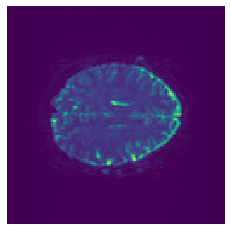

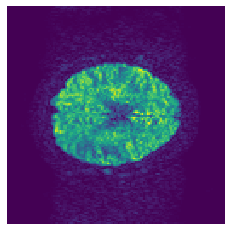

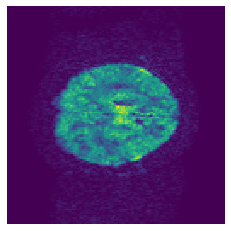

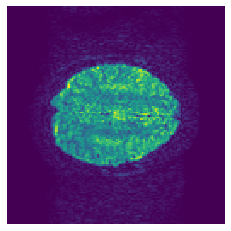

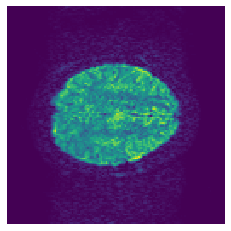

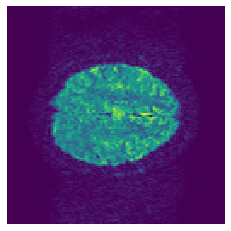

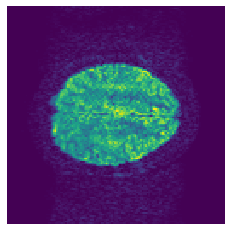

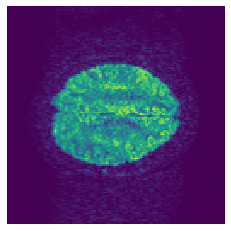

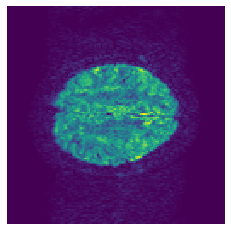

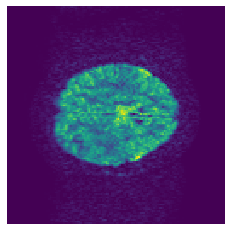

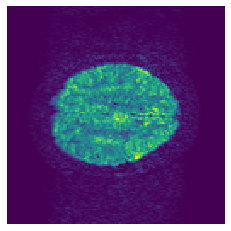

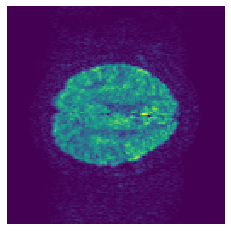

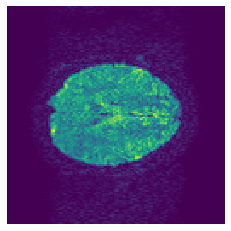

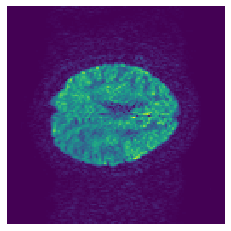

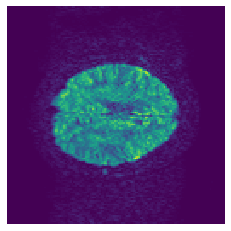

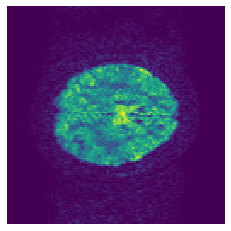

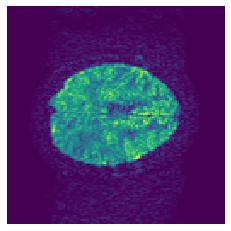

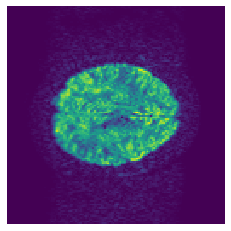

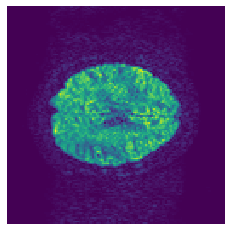

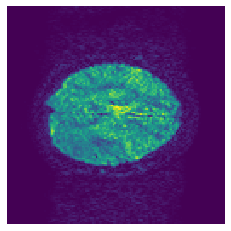

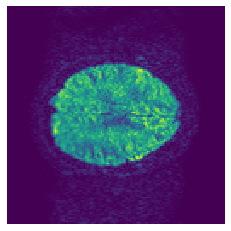

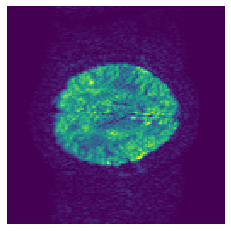

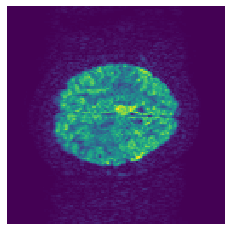

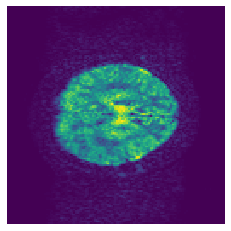

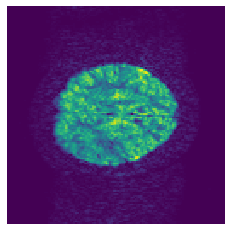

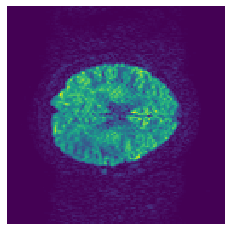

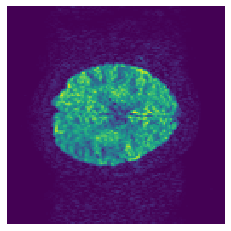

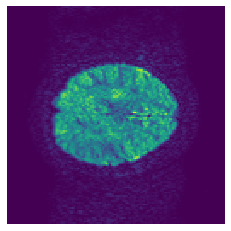

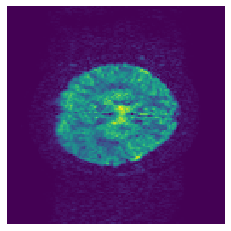

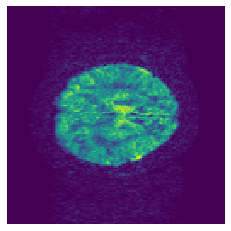

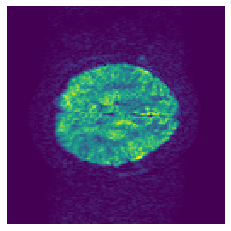

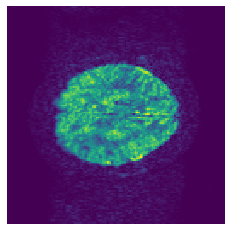

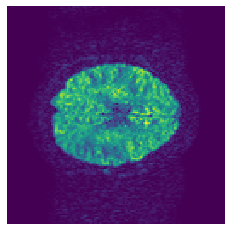

In [ ]:
for ii in range(data.shape[-1]):
    fig, ax = plt.subplots()
    ax.matshow(data[:, :, data.shape[2]//2, ii])
    ax.axis("off")
    fig.savefig(f"/Users/arokem/tmp/uncorrected{ii:03d}.png")

In [ ]:
b0_mask, mask = median_otsu(data, vol_idx=[0], median_radius=2, numpass=1)

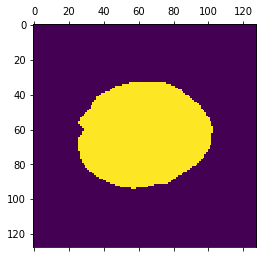

In [ ]:
plt.matshow(mask[:, :, mask.shape[-1]//2])

In [ ]:
# # We fix b0 to be one volume, registered to one of the
# # b0 volumes (first, per default):
# if np.sum(gtab.b0s_mask) > 1:
#     b0_img = nib.Nifti1Image(data[..., gtab.b0s_mask], affine)
#     trans_b0, b0_affines = dpa.register_series(b0_img, ref=b0_ref)
#     ref_data = np.mean(trans_b0, -1)[..., np.newaxis]
# else:
#     # There's only one b0 and we register everything to it
#     trans_b0 = ref_data = data[..., gtab.b0s_mask]

# moving_data = data[..., ~gtab.b0s_mask]
# moving_bvals = gtab.bvals[~gtab.b0s_mask]
# moving_bvecs = gtab.bvecs[~gtab.b0s_mask]
# mask = np.ones(ref_data.shape[:3])
# mask[np.where(ref_data[..., 0] == 0)] = 0


In [ ]:
# loo = 0 
# loo_idxer = np.ones(moving_data.shape[-1]).astype(bool)
# loo_idxer[loo] = False

# in_data = np.concatenate([ref_data, moving_data[..., loo_idxer]], -1)
# in_gtab = dpg.gradient_table(
#     np.concatenate([np.array([0]), moving_bvals[loo_idxer]]),
#     np.concatenate([np.array([[0, 0, 0]]), moving_bvecs[loo_idxer]]))


In [ ]:
# sfm = SFM4HMC(
#     in_gtab,
#     isotropic=ExponentialIsotropicModel)

In [ ]:
# sff = sfm.fit(in_data, mask=mask, frac=0.9)

In [ ]:
# pred = sff.predict(in_gtab)

In [ ]:
# pred.shape

In [ ]:
# in_data.shape

In [ ]:
# import matplotlib.pyplot as plt

In [ ]:
# plt.plot(in_data[64, 64, 30])
# plt.plot(pred[64, 64, 30])

In [ ]:
# out_data = moving_data[..., ~loo_idxer]
# out_gtab = dpg.gradient_table(moving_bvals[~loo_idxer],
#                                 moving_bvecs[~loo_idxer])

# out_pred = sff.predict(out_gtab, S0=ref_data[..., 0])


In [ ]:
# out_data.shape, out_pred.shape

In [ ]:
# foo = np.sqrt((out_data[:, :, 30, 0] - out_pred[:, :, 30])**2)

In [ ]:
# foo.shape

In [ ]:
# plt.matshow(foo)

In [ ]:
# plt.matshow(out_data[:, :, 30])
# plt.matshow(out_pred[:, :, 30], vmin=0)

In [ ]:
# np.max(out_data), np.max(out_pred), np.min(out_data), np.min(out_pred)

In [ ]:
import time

In [ ]:
xform_img, affine_array = dpa.register_dwi_series(img, gtab, pipeline=[dpa.center_of_mass, dpa.rigid])

In [ ]:
affine_array.shape

(4, 4, 33)

In [ ]:
gtab.b0s_mask

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [ ]:
gtab.bvals.shape

(33,)

In [ ]:
new_gtab = dpg.reorient_bvecs(gtab, affine_array)

ValueError: Number of affine transformations must match number of non-zero gradients

In [ ]:
data_for_reg = xform_img.get_fdata()

<ipython-input-120-f7005bf1f9ac>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


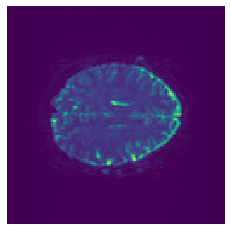

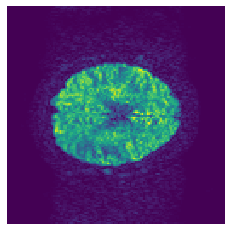

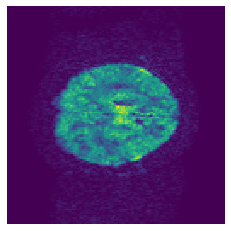

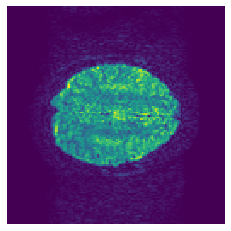

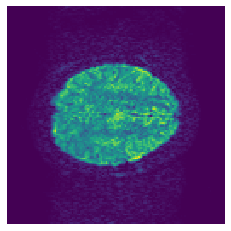

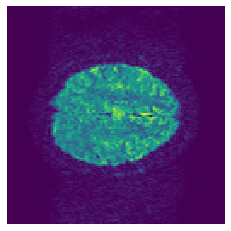

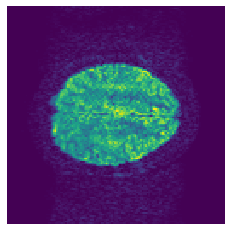

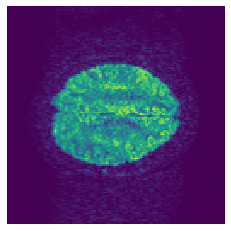

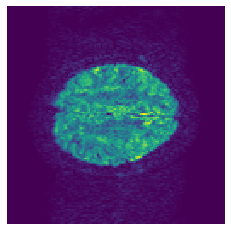

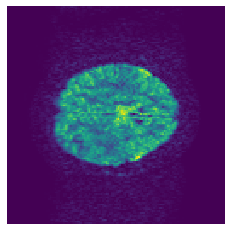

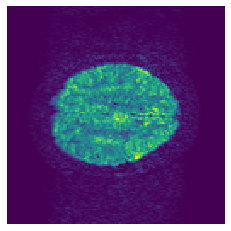

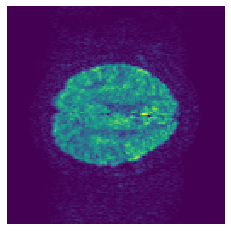

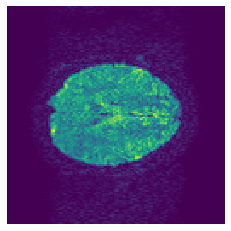

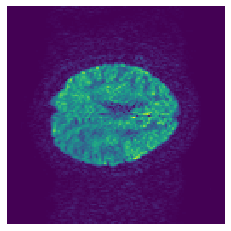

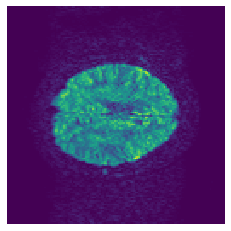

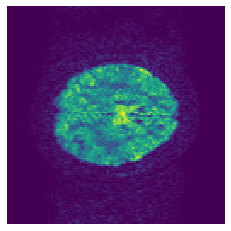

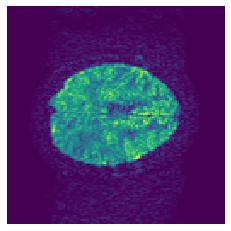

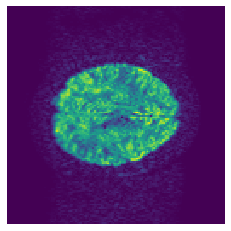

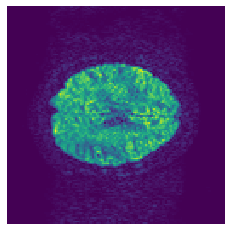

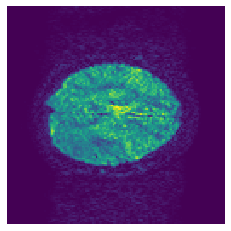

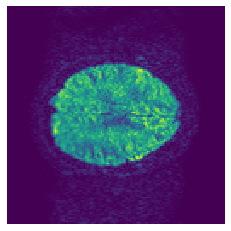

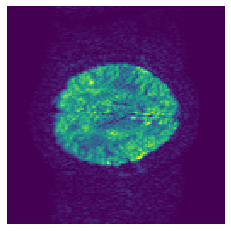

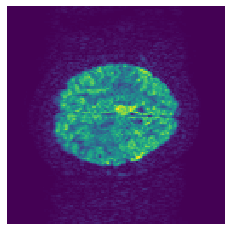

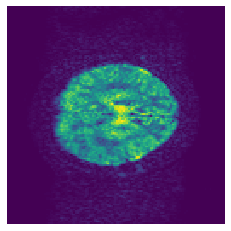

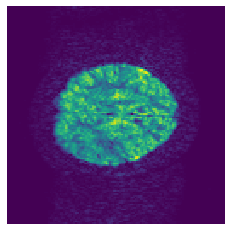

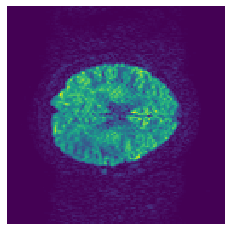

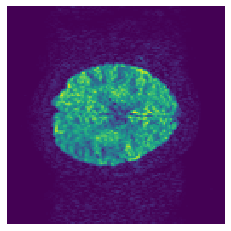

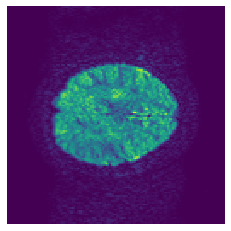

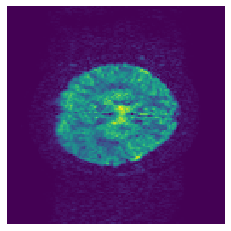

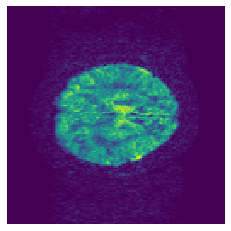

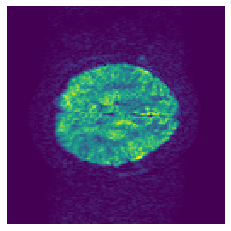

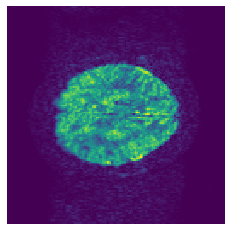

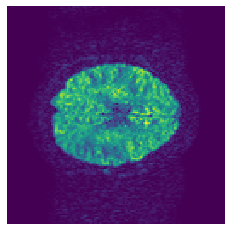

In [ ]:
for ii in range(data.shape[-1]):
    fig, ax = plt.subplots()
    ax.matshow(data[:, :, data.shape[2]//2, ii])
    ax.axis("off")
    fig.savefig(f"/Users/arokem/tmp/corrected_first_pass{ii:03d}.png")

In [ ]:
#export
def hmc(data, gtab, mask=None, b0_ref=0, affine=None):
    data, affine = read_img_arr_or_path(data, affine=affine)
    if isinstance(gtab, collections.Sequence):
        gtab = dpg.gradient_table(*gtab)

    # We fix b0 to be one volume, registered to one of the
    # b0 volumes (first, per default):
    if np.sum(gtab.b0s_mask) > 1:
        b0_img = nib.Nifti1Image(data[..., gtab.b0s_mask], affine)
        trans_b0, b0_affines = dpa.register_series(b0_img, ref=b0_ref)
        ref_data = np.mean(trans_b0, -1)[..., np.newaxis]
    else:
        # There's only one b0 and we register everything to it
        trans_b0 = ref_data = data[..., gtab.b0s_mask]

    moving_data = data[..., ~gtab.b0s_mask]
    moving_bvals = gtab.bvals[~gtab.b0s_mask]
    moving_bvecs = gtab.bvecs[~gtab.b0s_mask]
    mask = np.ones(ref_data.shape[:3], dtype=bool)
    mask[np.where(ref_data[..., 0] == 0)] = False
    moved = []
    affines = []

    # We fit the isotropic prediction once for all the data:
    sfm_all = SFM4HMC(
        gtab,
        isotropic=ExponentialIsotropicModel)

    sff_all, iso_params = sfm_all.fit(data, alpha=10e-10, mask=mask, tol=10e-10, iso_params=None)

    for loo in range(moving_data.shape[-1]):
        print(loo)
        loo_idxer = np.ones(moving_data.shape[-1]).astype(bool)
        loo_idxer[loo] = False

        in_data = np.concatenate([ref_data, moving_data[..., loo_idxer]], -1)
        in_gtab = dpg.gradient_table(
            np.concatenate([np.array([0]), moving_bvals[loo_idxer]]),
            np.concatenate([np.array([[0, 0, 0]]), moving_bvecs[loo_idxer]]))

        sfm = SFM4HMC(
            in_gtab,
            isotropic=ExponentialIsotropicModel)

        t1 = time.time()
        sff, _ = sfm.fit(in_data, mask=mask, alpha=10e-10, iso_params=iso_params)
        t2 = time.time()
        print(t2 - t1)
        out_data = moving_data[..., ~loo_idxer]
        out_gtab = dpg.gradient_table(moving_bvals[~loo_idxer],
                                      moving_bvecs[~loo_idxer])

        out_pred = sff.predict(out_gtab, S0=ref_data[..., 0])
        t1 = time.time()
        resampled, out_affine = dpa.affine_registration(
            out_data[..., 0],
            out_pred,
            moving_affine=affine,
            static_affine=affine,
            pipeline=[dpa.affine],
            level_iters=[100, 10, 10])
        t2 = time.time()
        print(t2 - t1)
        moved.append(resampled)
        affines.append(out_affine)
        in_data[..., loo] = resampled
        # XXX Also rotate the b-vector here
        new_out_gtab = dpg.reorient_bvecs(out_gtab, [out_affine])
        moving_bvals[~loo_idxer] = new_out_gtab.bvals
        moving_bvecs[~loo_idxer] = new_out_gtab.bvecs

    return moved, affines

# Reuse USV from a single SVD decomposition of X at the beginning of each
# loop through all of the volumes. Should speed up the RR fit in every volume.
# <= We can't do that, because the directions are different each time

# Use a sliding window to fit only to n nearest neighbors.

# Fit isotropic component once per voxel and be done with it

In [ ]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
%lprun -f ExponentialIsotropicFit.predict  moved, affines = hmc(data_for_reg, gtab, mask=mask, b0_ref=0, affine=img.affine)

0
2.016756296157837


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
12.68940806388855
1


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.113651990890503


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.752158880233765
2


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.278291940689087


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.063847780227661
3


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.275952100753784


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.656738758087158
4


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.157672166824341


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
16.4257390499115
5


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.1549277305603027


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
8.04787802696228
6


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.140951156616211


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.820778846740723
7


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.1766889095306396


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
10.261772155761719
8


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.420954942703247


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.515538215637207
9


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.135883092880249


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
8.711658954620361
10


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.143404245376587


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.874544858932495
11


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.1429617404937744


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
22.835921049118042
12


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.22652530670166


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.531994104385376
13


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.1375272274017334


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.457277059555054
14


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2531909942626953


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.880541086196899
15


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.1298279762268066


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
15.107736110687256
16


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.1520230770111084


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
13.903420209884644
17


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.189239263534546


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
15.26170301437378
18


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2537729740142822


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
22.60016703605652
19


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.1907718181610107


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.999881029129028
20


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2275681495666504


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.621636867523193
21


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2439732551574707


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
9.527183771133423
22


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2635440826416016


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.2053000926971436
23


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.281522274017334


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.819072008132935
24


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.275965929031372


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
16.911881923675537
25


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.309858798980713


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
8.06194806098938
26


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.305593252182007


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.673864364624023
27


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2673091888427734


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.434432029724121
28


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2770681381225586


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.273530721664429
29


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.380373001098633


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
6.915078163146973
30


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.271411180496216


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
7.493139982223511
31


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


2.2378108501434326


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


Optimizing level 2 [max iter: 100]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 10]
8.346840858459473


/Users/arokem/source/dipy/dipy/core/gradients.py:295: UserWarning: b0_threshold (value: 50) is too low, increase your              b0_threshold. It should be higher than the lowest b0 value              (1000.0).
  warn("b0_threshold (value: {0}) is too low, increase your \


In [ ]:
moved_arr=np.array(moved)

In [ ]:
data.shape

(128, 128, 50, 33)

In [ ]:
moved_arr.shape

(32, 128, 128, 50)

<ipython-input-135-c9099a824972>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


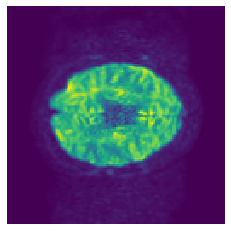

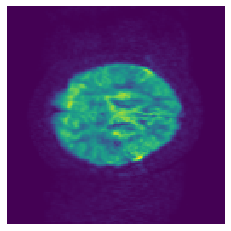

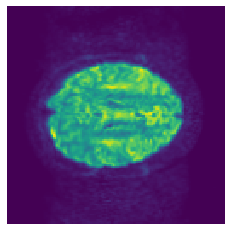

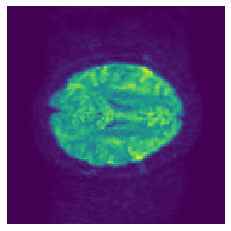

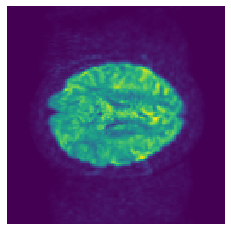

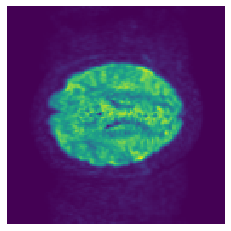

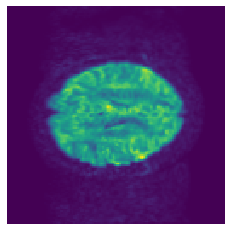

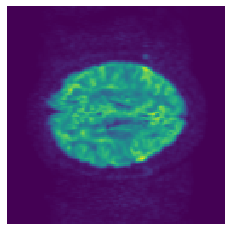

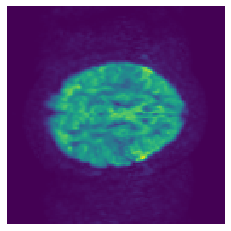

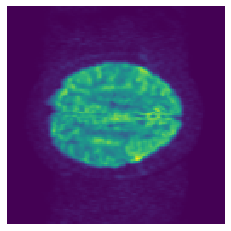

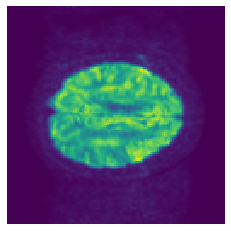

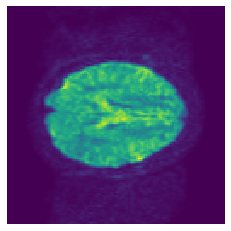

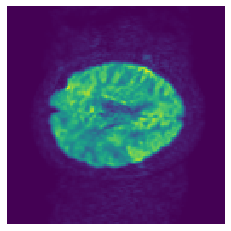

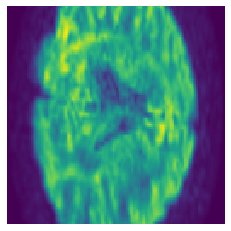

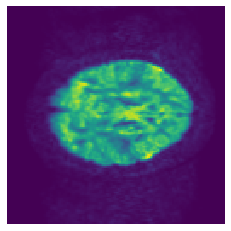

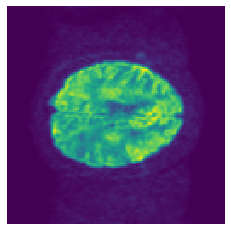

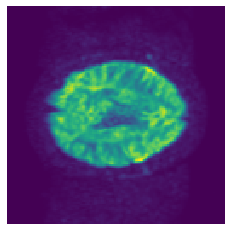

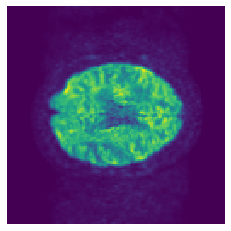

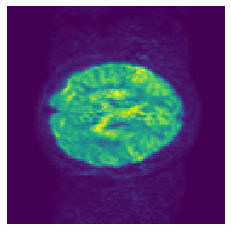

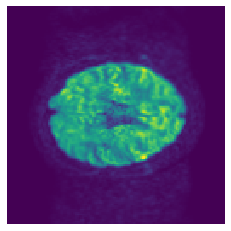

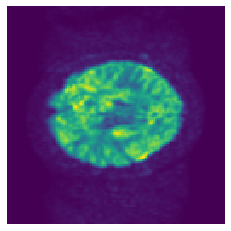

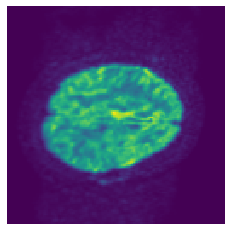

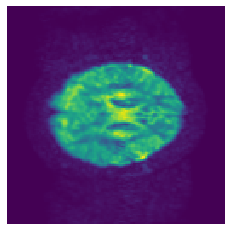

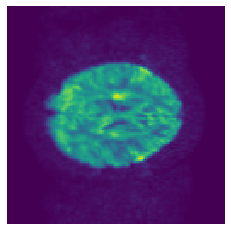

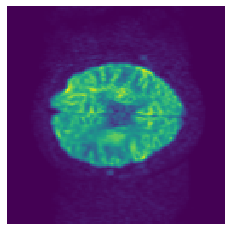

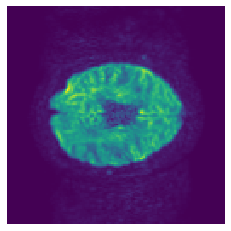

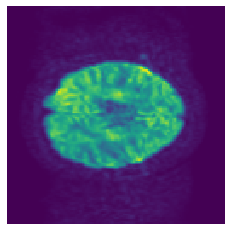

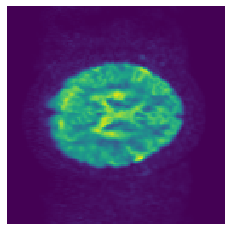

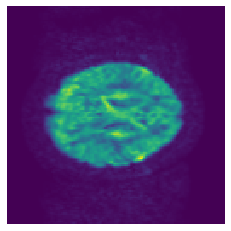

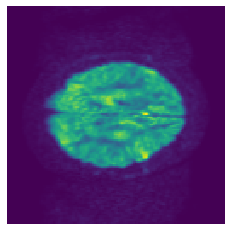

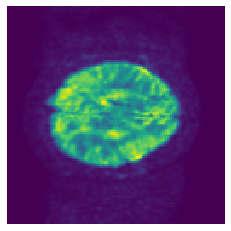

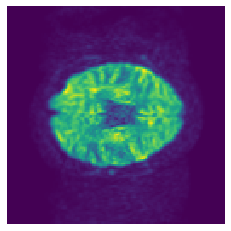

In [ ]:
for ii in range(moved_arr.shape[0]):
    fig, ax = plt.subplots()
    ax.matshow(moved_arr[ii, :, :, moved_arr.shape[-1]//2])
    ax.axis("off")
    fig.savefig(f"/Users/arokem/tmp/corrected{ii+1:03d}.png")